In [1]:
import pandas as pd
import numpy as np
import re
from indicnlp.tokenize import sentence_tokenize, indic_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [2]:
# Load the dataset from the CSV file
csv_file_path = 'Labeling.csv' 
df = pd.read_csv(csv_file_path)

In [3]:
# Handling missing values: Replace NaN with an empty string for comments
df['comments'] = df['Comments'].fillna('')

In [4]:
# Preprocess Bengali text
bengali_comments = []
for comment in df['comments']:
    # Check if the comment is a string or bytes-like object
    if isinstance(comment, (str, bytes)):
        sentences = sentence_tokenize.sentence_split(comment, lang='bn')
        words_list = []
        for sentence in sentences:
            words = indic_tokenize.trivial_tokenize(sentence, lang='bn')
            words_list.extend(words)
        bengali_comments.append(' '.join(words_list))

In [5]:
# Remove special characters and numbers
bengali_comments = [re.sub(r'[^ঀ-৾\s]', '', comment) for comment in bengali_comments]

In [6]:
# Map the 'yes' and 'no' labels to binary values (1 and 0)
label_mapping = {'yes': 1, 'no': 0}
labels = [label_mapping[label.lower()] for label in df['label']]

In [7]:
# Convert the labels to a NumPy array
encoded_labels = np.array(labels)

In [8]:
# Initialize the Tokenizer
tokenizer = Tokenizer()

In [9]:
# Fit the tokenizer on the comments to create a word-to-index dictionary
tokenizer.fit_on_texts(bengali_comments)

In [10]:
# Convert the comments to sequences of integers
sequences = tokenizer.texts_to_sequences(bengali_comments)

In [11]:
# Vocabulary size 
vocab_size = len(tokenizer.word_index) + 1

In [12]:
# Save the word-to-index dictionary to a .npy file
word_index_file_path = 'C:\\Users\\Models\\Labeling_index.npy'
np.save(word_index_file_path, tokenizer.word_index)

In [13]:
# Maximum sequence length 
max_sequence_length = 300

In [14]:
# Pad the sequences to make them of equal length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

In [16]:
# Build the RNN Model
model = Sequential()
embedding_dim = 200
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
lstm_units = 64
model.add(LSTM(units=lstm_units))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# Train the Model
epochs = 15  # Choose the number of training epochs
batch_size = 32  # Choose the batch size
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/15
110/110 [==============================] - 26s 215ms/step - loss: 0.4947 - accuracy: 0.8048 - val_loss: 0.4689 - val_accuracy: 0.7882
Epoch 2/15
110/110 [==============================] - 27s 248ms/step - loss: 0.2699 - accuracy: 0.8880 - val_loss: 0.4703 - val_accuracy: 0.8166
Epoch 3/15
110/110 [==============================] - 30s 273ms/step - loss: 0.0656 - accuracy: 0.9815 - val_loss: 0.6422 - val_accuracy: 0.8212
Epoch 4/15
110/110 [==============================] - 28s 253ms/step - loss: 0.0192 - accuracy: 0.9943 - val_loss: 0.7906 - val_accuracy: 0.8155
Epoch 5/15
110/110 [==============================] - 27s 243ms/step - loss: 0.0147 - accuracy: 0.9960 - val_loss: 0.8427 - val_accuracy: 0.7973
Epoch 6/15
110/110 [==============================] - 27s 250ms/step - loss: 0.0071 - accuracy: 0.9986 - val_loss: 0.8783 - val_accuracy: 0.8166
Epoch 7/15
110/110 [==============================] - 27s 249ms/step - loss: 0.0041 - accuracy: 0.9997 - val_loss: 0.9555 - val_ac

In [18]:
# Save the Entire Model
model.save('C:\\Users\\Models\\Labeling_model.h5')

D:\Program file\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
# Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

28/28 [==============================] - 1s 51ms/step - loss: 1.3790 - accuracy: 0.8041
Test loss: 1.3790247440338135
Test accuracy: 0.8041002154350281


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the Model
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

28/28 [==============================] - 2s 50ms/step
Performance Metrics:
Accuracy: 0.80
Precision: 0.55
Recall: 0.50
F1-Score: 0.52
ROC-AUC: 0.77


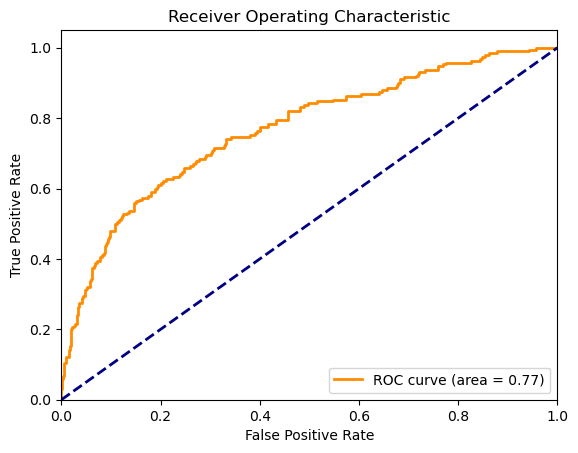

In [21]:
# Graphical Representation (ROC Curve)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()